<a href="https://colab.research.google.com/github/mohammadabid-macad/AIAStudioG03/blob/main/Notebooks/Facade_Calc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Part A

## Cell A0: Install Required Libraries

In [ ]:
!pip install requests Pillow torch transformers matplotlib numpy tensorflow


  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21

## Cell A1: Import Libraries and Define Functions

In [ ]:
import requests
from PIL import Image
import torch
from transformers import DPTFeatureExtractor, DPTForSemanticSegmentation
import matplotlib.pyplot as plt
import numpy as np
from io import BytesIO
import tensorflow as tf
from collections import defaultdict
import joblib

# Function to download and preprocess the image
def download_image(url):
    response = requests.get(url)
    img = Image.open(BytesIO(response.content)).convert("RGB")
    return img

# Function to calculate class percentages
def calculate_class_percentages(predicted_labels, classes):
    total_pixels = predicted_labels.size
    percentages = {class_id: np.sum(predicted_labels == class_id) / total_pixels * 100 for class_id in classes.keys()}
    return percentages

# Function to preprocess patches from the building segment for the material classifier
def extract_patches(building_image, patch_size=128, stride=64):
    building_array = np.array(building_image)
    h, w, _ = building_array.shape
    patches = []
    for i in range(0, h - patch_size + 1, stride):
        for j in range(0, w - patch_size + 1, stride):
            patch = building_array[i:i+patch_size, j:j+patch_size]
            if np.sum(patch) > 0:  # Avoid patches with only background
                patches.append(patch)
    patches = np.array(patches) / 255.0
    return patches

# Load segmentation model and feature extractor
feature_extractor = DPTFeatureExtractor.from_pretrained("Intel/dpt-large-ade")
segmentation_model = DPTForSemanticSegmentation.from_pretrained("Intel/dpt-large-ade")

# Load your material texture classifier model
classifier_model_url = "https://github.com/mohammadabid-macad/AIAStudioG03/raw/65f48a58e1f1ea1c8ac387facfa78a6ba20b467d/models/material_texture_classifier.keras"
response = requests.get(classifier_model_url)
classifier_model_path = 'material_texture_classifier.keras'
with open(classifier_model_path, 'wb') as file:
    file.write(response.content)
classifier_model = tf.keras.models.load_model(classifier_model_path)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/285 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/dpt/feature_extraction_dpt.py:28: FutureWarning: The class DPTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use DPTImageProcessor instead.
  warnings.warn(


config.json:   0%|          | 0.00/6.91k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.37G [00:00<?, ?B/s]

Some weights of DPTForSemanticSegmentation were not initialized from the model checkpoint at Intel/dpt-large-ade and are newly initialized: ['neck.fusion_stage.layers.0.residual_layer1.batch_norm1.bias', 'neck.fusion_stage.layers.0.residual_layer1.batch_norm1.num_batches_tracked', 'neck.fusion_stage.layers.0.residual_layer1.batch_norm1.running_mean', 'neck.fusion_stage.layers.0.residual_layer1.batch_norm1.running_var', 'neck.fusion_stage.layers.0.residual_layer1.batch_norm1.weight', 'neck.fusion_stage.layers.0.residual_layer1.batch_norm2.bias', 'neck.fusion_stage.layers.0.residual_layer1.batch_norm2.num_batches_tracked', 'neck.fusion_stage.layers.0.residual_layer1.batch_norm2.running_mean', 'neck.fusion_stage.layers.0.residual_layer1.batch_norm2.running_var', 'neck.fusion_stage.layers.0.residual_layer1.batch_norm2.weight', 'neck.fusion_stage.layers.0.residual_layer1.convolution1.weight', 'neck.fusion_stage.layers.0.residual_layer1.convolution2.weight']
You should probably TRAIN this mo

## Cell A2: Segment Image and Extract Material Percentages

Background: 42.17%
Foliage: 26.93%
Building: 30.90%
Sky: 0.00%


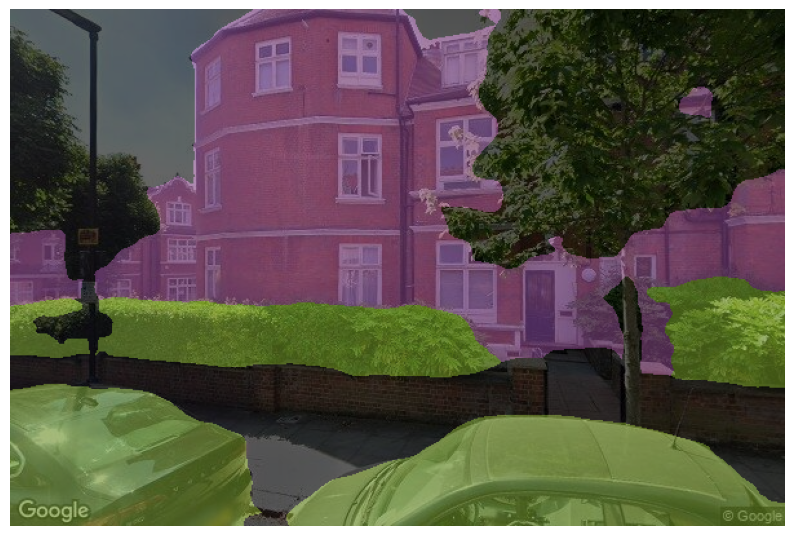

In [ ]:
# URL of the image to be segmented
image_url = "https://github.com/mohammadabid-macad/AIAStudioG03/blob/main/images/building_('relation',%2013633251)_heading_150.58533804394392.jpg?raw=true"

# Download and preprocess the image
original_image = download_image(image_url)
inputs = feature_extractor(images=original_image, return_tensors="pt")

# Perform segmentation
with torch.no_grad():
    outputs = segmentation_model(**inputs)
    logits = outputs.logits
    upsampled_logits = torch.nn.functional.interpolate(logits, size=original_image.size[::-1], mode="bilinear", align_corners=False)
    predicted_labels = upsampled_logits.argmax(dim=1).squeeze().numpy()

# Define the class mappings
foliage_classes = [8, 10, 12, 17, 18, 19, 20]  # Example foliage classes, adjust as necessary
building_class = 1
sky_class = 22

# Create a new map for the desired classes
new_predicted_labels = np.zeros_like(predicted_labels)
new_predicted_labels[np.isin(predicted_labels, foliage_classes)] = 1  # Foliage
new_predicted_labels[predicted_labels == building_class] = 2  # Building
new_predicted_labels[predicted_labels == sky_class] = 3  # Sky

# Define the colors and names for each class
classes = {
    0: {"name": "Background", "color": [0, 0, 0]},
    1: {"name": "Foliage", "color": [107, 142, 35]},
    2: {"name": "Building", "color": [128, 64, 128]},
    3: {"name": "Sky", "color": [135, 206, 235]}
}

# Calculate percentage for each class
percentages = calculate_class_percentages(new_predicted_labels, classes)

# Print the percentages with class names
for class_id, percentage in percentages.items():
    print(f"{classes[class_id]['name']}: {percentage:.2f}%")

# Visualize the segmentation
colored_segmentation = np.zeros((new_predicted_labels.shape[0], new_predicted_labels.shape[1], 3), dtype=np.uint8)
for class_id, class_info in classes.items():
    colored_segmentation[new_predicted_labels == class_id] = class_info["color"]

plt.figure(figsize=(10, 10))
plt.imshow(original_image)
plt.imshow(colored_segmentation, alpha=0.6)
plt.axis('off')
plt.show()


## Cell A3: Extract Building Segment and Classify Materials

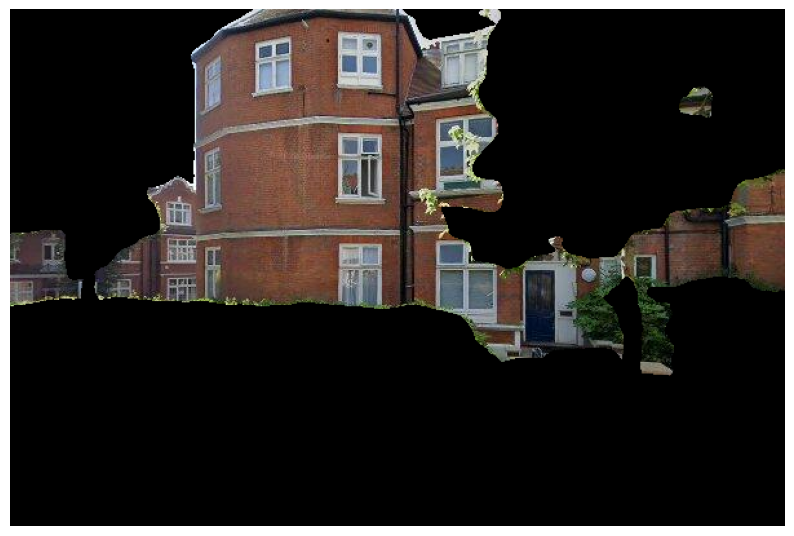

Patches shape: (34, 128, 128, 3)
2/2 [==============================] - 0s 20ms/step
Material predictions shape: (34, 11)
Argmax index: 3, Prediction: [0.07596049 0.08985624 0.17560181 0.28795546 0.00060592 0.04225439
 0.02406343 0.08944753 0.06572686 0.07710902 0.07141891]
Argmax index: 0, Prediction: [0.21754916 0.20113824 0.09201887 0.1380819  0.00032407 0.05160667
 0.00553321 0.06384068 0.07240619 0.01272353 0.14477749]
Argmax index: 0, Prediction: [3.2413927e-01 9.9428974e-02 7.0565633e-02 4.7549177e-02 4.1655006e-05
 2.2818750e-02 1.2455407e-03 8.2199305e-02 4.3839812e-02 4.8419628e-03
 3.0332989e-01]
Argmax index: 0, Prediction: [3.6484149e-01 2.7707081e-02 3.1272194e-01 3.1358335e-02 6.5938104e-07
 7.6740904e-04 1.2195994e-03 2.3036052e-01 6.0586603e-03 4.5756614e-03
 2.0388646e-02]
Argmax index: 2, Prediction: [2.9606747e-03 1.3402627e-03 9.5449150e-01 3.5091322e-02 1.4095547e-08
 3.6957840e-04 3.0702580e-05 3.1617216e-03 1.2635806e-03 4.0596593e-04
 8.8463037e-04]
Argmax inde

In [ ]:
# Extract the building segment
building_mask = (new_predicted_labels == 2)
building_segment = np.array(original_image) * np.repeat(building_mask[:, :, np.newaxis], 3, axis=2)

# Convert the building segment back to an image
building_image = Image.fromarray(building_segment.astype('uint8'))

# Visualize the building segment
plt.figure(figsize=(10, 10))
plt.imshow(building_image)
plt.axis('off')
plt.show()

# Extract patches
patches = extract_patches(building_image)

# Debugging: Print the shape of the patches
print(f"Patches shape: {patches.shape}")

# Classify each patch
material_predictions = classifier_model.predict(patches)

# Debugging: Print the shape of the predictions
print(f"Material predictions shape: {material_predictions.shape}")

material_classes = ['brick', 'ceramic', 'glass', 'metal', 'paint', 'stone', 'tile', 'wood']
material_counts = {material: 0 for material in material_classes}

for pred in material_predictions:
    argmax_index = np.argmax(pred)
    # Debugging: Print the argmax index and the corresponding prediction
    print(f"Argmax index: {argmax_index}, Prediction: {pred}")
    if argmax_index < len(material_classes):
        material_class = material_classes[argmax_index]
        material_counts[material_class] += 1

# Calculate percentages for each material in the building segment
total_building_patches = len(patches)
material_percentages = {material: (count / total_building_patches) * 100 for material, count in material_counts.items()}

# Print the material classification results with percentages
for material, percentage in material_percentages.items():
    print(f"{material}: {percentage:.2f}%")


# Part B

## 00: Install Dependencies

In [ ]:
!pip install osmnx geopandas shapely pandas pyproj requests tensorflow


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.2/107.2 kB 2.7 MB/s eta 0:00:00


In [ ]:
import osmnx as ox
import geopandas as gpd
from shapely.geometry import Point, LineString
import pandas as pd
import pyproj
import requests
import tensorflow as tf

## 01: Define Sample Data

In [ ]:
# Sample values for material percentages
brick_percentage = 0.45779499411582947
ceramic_percentage = 0.058589570224285126
glass_percentage = 0.03563307225704193
metal_percentage = 0.000011294204341538716
painted_percentage = 0.015030953101813793
tile_percentage = 0.07241785526275635
wood_percentage = 0.20852695405483246

# Given latitude and longitude values from the sample data
lat, lon = 51.52748,-0.16664

# Print sample data
print(f"Sample data: lat={lat}, lon={lon}, brick_percentage={brick_percentage}")


Sample data: lat=51.52748, lon=-0.16664, brick_percentage=0.45779499411582947


## 02: Load OSMnx Graph and Buildings

In [ ]:
# Create a bounding box around the given coordinates
distance = 1000  # distance in meters for the bounding box
bbox = ox.utils_geo.bbox_from_point(point=(lat, lon), dist=distance)

# Load the OSMnx graph for the bounding box
G = ox.graph_from_bbox(bbox[0], bbox[1], bbox[2], bbox[3], network_type='all')
buildings = ox.geometries_from_bbox(bbox[0], bbox[1], bbox[2], bbox[3], tags={'building': True})

# Calculate the distance from the given point to all building centroids and find the closest building
buildings['centroid'] = buildings.centroid
given_point = Point(lon, lat)
buildings['distance'] = buildings['centroid'].apply(lambda x: x.distance(given_point))
closest_building = buildings.loc[buildings['distance'].idxmin()]

# Retrieve the corresponding building polygon
building_polygon = closest_building['geometry']

# Print closest building information
osm_id = closest_building.name  # OSM ID is usually stored in the index
building_name = closest_building.get('name', 'N/A')  # Attempt to get the building name if available
print(f"Closest building OSM ID: {osm_id}")
print(f"Closest building name: {building_name}")
print(f"Closest building centroid: {closest_building['centroid']}, Distance: {closest_building['distance']}")


<ipython-input-8-c629ddf294d9>:6: FutureWarning: The `north`, `south`, `east`, and `west` parameters are deprecated and will be removed in the v2.0.0 release. Use the `bbox` parameter instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  G = ox.graph_from_bbox(bbox[0], bbox[1], bbox[2], bbox[3], network_type='all')
<ipython-input-8-c629ddf294d9>:7: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  buildings = ox.geometries_from_bbox(bbox[0], bbox[1], bbox[2], bbox[3], tags={'building': True})
/usr/local/lib/python3.10/dist-packages/osmnx/geometries.py:48: FutureWarning: The `north`, `south`, `east`, and `west` parameters are deprecated and will be removed in 

Closest building OSM ID: ('way', 27005024)
Closest building name: Simpson House
Closest building centroid: POINT (-0.1668240735459621 51.5273881595217), Distance: 0.00020571277008745999


<ipython-input-8-c629ddf294d9>:10: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  buildings['centroid'] = buildings.centroid


## 03: Convert CRS and Explode Building Polygons

In [ ]:
# Define the CRS (Coordinate Reference System) based on the given latitude and longitude
utm_crs = ox.projection.project_gdf(gpd.GeoDataFrame(geometry=[Point(lon, lat)], crs='EPSG:4326')).crs

# Convert the closest building and street network to the UTM CRS
closest_building_gdf = gpd.GeoDataFrame([closest_building], crs=buildings.crs).set_geometry('geometry')
closest_building_gdf = closest_building_gdf.to_crs(utm_crs)
street_edges = ox.graph_to_gdfs(G, nodes=False).to_crs(utm_crs)

# Function to explode the building polygon into edges
def extract_edges(polygon):
    if polygon.geom_type == 'Polygon':
        return [LineString([polygon.exterior.coords[i], polygon.exterior.coords[i+1]]) for i in range(len(polygon.exterior.coords)-1)]
    return []

# Extract edges for the closest building
closest_building_edges = extract_edges(closest_building_gdf.geometry.iloc[0])

# Buffer the street edges
buffered_street_edges = street_edges.buffer(10)

# Function to calculate street-facing edge lengths
def calculate_street_facing_edges(edges, buffer_gdf):
    street_facing_edges = [edge for edge in edges if buffer_gdf.intersects(edge).any()]
    return street_facing_edges

# Calculate street-facing edges
street_facing_edges = calculate_street_facing_edges(closest_building_edges, buffered_street_edges)

# Print CRS and edge information
print(f"UTM CRS: {utm_crs}")
print(f"Total number of building edges: {len(closest_building_edges)}")
print(f"Number of street-facing edges: {len(street_facing_edges)}")


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/pyproj/transformer.py:820: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return self._transformer._transform_point(


UTM CRS: EPSG:32630
Total number of building edges: 9
Number of street-facing edges: 9


## 04: Load Trained Model

In [ ]:
import joblib
import requests

# Define the new model and scaler URLs
model_url = "https://github.com/mohammadabid-macad/AIAStudioG03/raw/65f48a58e1f1ea1c8ac387facfa78a6ba20b467d/models/studio_trained_controlled.keras"
scaler_url = "https://github.com/mohammadabid-macad/AIAStudioG03/raw/65f48a58e1f1ea1c8ac387facfa78a6ba20b467d/models/Sscaler_nooutlier.pkl"

# Download the new model
response = requests.get(model_url)
model_path = 'studio_trained_controlled.keras'
with open(model_path, 'wb') as file:
    file.write(response.content)

# Download the scaler
response = requests.get(scaler_url)
scaler_path = 'Sscaler_nooutlier.pkl'
with open(scaler_path, 'wb') as file:
    file.write(response.content)

# Load the new model
model = tf.keras.models.load_model(model_path)

# Load the scaler
scaler = joblib.load(scaler_path)

# Print model summary to verify loading
model.summary()

# Print scaler information to verify loading
print("Scaler loaded successfully")


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                1216      
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 5441 (21.25 KB)
Trainable params: 5441 (21.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Scaler loaded successfully


## 05: Map Building Categories

In [ ]:
# Mapping dictionary for building categories
building_type_mapping = {
    'house': 'residential',
    'apartments': 'residential',
    'residential': 'residential',
    'semidetached_house': 'residential',
    'terrace': 'residential',
    'dormitory': 'residential',
    'retail': 'retail',
    'commercial': 'commercial',
    'detached': 'residential',
    'garages': 'other',
    'office': 'office',
    'university': 'education',
    'school': 'education',
    'garage': 'other',
    'roof': 'other',
    'church': 'religious',
    'shed': 'other',
    'service': 'other',
    'industrial': 'industrial',
    'train_station': 'transport',
    'hotel': 'hospitality',
    'pub': 'hospitality',
    'air_shaft': 'other',
    'warehouse': 'industrial',
    'hospital': 'healthcare',
    'construction': 'other',
    'public': 'institution',
    'bridge': 'transport',
    'college': 'education',
    'kiosk': 'commercial',
    'civic': 'institution',
    'block': 'other',
    'no': 'other',
    'healthcare': 'healthcare',
    'bunker': 'other',
    'toilets': 'public',
    'hall_of_residence': 'education',
    'restaurant': 'hospitality',
    'kindergarten': 'education',
    'greenhouse': 'other',
    'conservatory': 'other',
    'tower': 'other',
    'hut': 'other',
    'museum': 'institution',
    'presbytery': 'religious',
    'outbuilding': 'other',
    'chapel': 'religious',
    'silo': 'industrial',
    'cafe': 'hospitality',
    'sports_centre': 'sports',
    'multiple': 'other',
    'air_vent': 'other',
    'commerical': 'commercial',
    'container': 'other',
    'student_residence': 'education',
    'shelter': 'public',
    'ruins': 'other',
    'substation': 'other',
    'transportation': 'transport',
    'balcony': 'other',
    'council_flats': 'residential',
    'disused_station': 'transport',
    'portacabins': 'other',
    'cinema': 'hospitality',
    'boathouse': 'other',
    'artists_studio': 'institution',
    'chimney': 'other',
    'vent_shaft': 'other',
    'library': 'institution',
    'gatehouse': 'institution',
    'sports_hall': 'sports',
    'convent': 'religious',
}

# Apply the mapping to categorize the closest building type
closest_building_category = building_type_mapping.get(closest_building['building'], 'other')
closest_building_gdf['building_category'] = closest_building_category

# Print building category
print(f"Closest building category: {closest_building_category}")


Closest building category: residential


## 06: Predict Building Height

In [ ]:
# Function to prepare features and predict building height
def predict_building_height(building):
    features = pd.DataFrame({
        "Building_FootprintArea": [building['geometry'].area],
        "Category_commercial": [1 if building.get('building_category') == 'commercial' else 0],
        "Category_education": [1 if building.get('building_category') == 'education' else 0],
        "Category_hospitality": [1 if building.get('building_category') == 'hospitality' else 0],
        "Category_industrial": [1 if building.get('building_category') == 'industrial' else 0],
        "Category_office": [1 if building.get('building_category') == 'office' else 0],
        "Category_residential": [1 if building.get('building_category') == 'residential' else 0],
        "Category_retail": [1 if building.get('building_category') == 'retail' else 0],
        "Category_nan": [0],  # Placeholder for missing category
        "latitude": [building['centroid'].y],
        "longitude": [building['centroid'].x],
        "brick": [brick_percentage],
        "ceramic": [ceramic_percentage],
        "glass": [glass_percentage],
        "metal": [metal_percentage],
        "painted": [painted_percentage],
        "tile": [tile_percentage],
        "wood": [wood_percentage]
    })

    # Debug print to check the features DataFrame
    print("Features DataFrame before scaling:")
    print(features)

    # Scale the features
    scaled_features = scaler.transform(features)

    # Debug print to check the scaled features
    print("Scaled Features DataFrame:")
    print(scaled_features)

    # Predict the height using the loaded model
    height_prediction = model.predict(scaled_features)

    # Debug print to check the predicted height
    print(f"Predicted building height: {height_prediction[0][0]}")

    return height_prediction[0][0]


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## 07: Calculate Facade Area

In [ ]:
# Function to calculate street-facing edge lengths
def calculate_street_facing_length(edges, buffer_gdf):
    total_length = 0
    for edge in edges:
        if buffer_gdf.intersects(edge).any():
            total_length += edge.length
    return total_length

# Function to calculate facade area
def calculate_facade_area(building, edges, buffer_gdf):
    if pd.notnull(building['building:levels']):
        building_levels = float(building['building:levels'])
        height_source = 'OSM'
    else:
        # Predict the building height if levels data is not available
        building_height = float(predict_building_height(building))
        building_levels = building_height / 3  # Assuming floor-to-floor height is 3 meters
        height_source = 'Prediction Model'

    floor_to_floor_height = 3.0  # meters
    building_height = building_levels * floor_to_floor_height
    facade_edge_length = float(calculate_street_facing_length(edges, buffer_gdf))
    facade_area = building_height * facade_edge_length

    print(f"Facade area: {facade_area}, Building height: {building_height}, Height source: {height_source}")
    return facade_area, building_height, height_source

# Calculate facade area for the closest building
closest_building_facade_area, closest_building_height, closest_building_height_source = calculate_facade_area(closest_building_gdf.iloc[0], street_facing_edges, buffered_street_edges)


Facade area: 2673.2227393497187, Building height: 21.0, Height source: OSM


## 08: Iterate Through Buildings and Calculate Facade Areas

In [ ]:
# Extract edges for the single building
building_edges = extract_edges(closest_building['geometry'])

# Print to debug
print("Extracted edges for the building:", building_edges)

# Store the calculated results from Cell 07 in the closest_building GeoDataFrame
closest_building_gdf['facade_area'] = closest_building_facade_area
closest_building_gdf['building_height'] = closest_building_height
closest_building_gdf['height_source'] = closest_building_height_source

# Print the closest building information for debugging
print("Closest building information:")
print(closest_building_gdf[['facade_area', 'building_height', 'height_source']])


Extracted edges for the building: [<LINESTRING (-0.167 51.528, -0.167 51.528)>, <LINESTRING (-0.167 51.528, -0.167 51.527)>, <LINESTRING (-0.167 51.527, -0.167 51.527)>, <LINESTRING (-0.167 51.527, -0.167 51.527)>, <LINESTRING (-0.167 51.527, -0.167 51.527)>, <LINESTRING (-0.167 51.527, -0.167 51.527)>, <LINESTRING (-0.167 51.527, -0.167 51.527)>, <LINESTRING (-0.167 51.527, -0.167 51.527)>, <LINESTRING (-0.167 51.527, -0.167 51.528)>]
Closest building information:
              facade_area  building_height height_source
way 27005024  2673.222739             21.0           OSM


<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _GenerativeAIImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _AltairImportHook.find_spec() not found; falling back to find_module()


## 09: Calculate Material Areas

In [ ]:
# Calculate material areas for the closest building
brick_area = closest_building_facade_area * brick_percentage
ceramic_area = closest_building_facade_area * ceramic_percentage
glass_area = closest_building_facade_area * glass_percentage
metal_area = closest_building_facade_area * metal_percentage
painted_area = closest_building_facade_area * painted_percentage
#stone_area = closest_building_facade_area * stone_percentage
tile_area = closest_building_facade_area * tile_percentage
wood_area = closest_building_facade_area * wood_percentage


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## 10: Display Building Information

In [ ]:
# Calculate material areas for the closest building
brick_area = closest_building_facade_area * brick_percentage
ceramic_area = closest_building_facade_area * ceramic_percentage
glass_area = closest_building_facade_area * glass_percentage
metal_area = closest_building_facade_area * metal_percentage
painted_area = closest_building_facade_area * painted_percentage
tile_area = closest_building_facade_area * tile_percentage
wood_area = closest_building_facade_area * wood_percentage

# Display the closest building information
print("Closest building information:")
print(f"Latitude: {closest_building['centroid'].y}")
print(f"Longitude: {closest_building['centroid'].x}")
print(f"OSM ID: {closest_building.name}")
print(f"Building Name: {closest_building['name']}")
print(f"Building Category: {closest_building_category}")
print(f"Building Footprint Area: {closest_building['geometry'].area} square meters")
print(f"Total Building Facade Area: {closest_building_facade_area} square meters")
print(f"Brick Area: {brick_area} square meters")
print(f"Ceramic Area: {ceramic_area} square meters")
print(f"Glass Area: {glass_area} square meters")
print(f"Metal Area: {metal_area} square meters")
print(f"Painted Area: {painted_area} square meters")
print(f"Tile Area: {tile_area} square meters")
print(f"Wood Area: {wood_area} square meters")
print(f"Building Height: {closest_building_height} meters")
print(f"Building Height Source: {closest_building_height_source}")


Closest building information:
Latitude: 51.5273881595217
Longitude: -0.16682407354596213
OSM ID: ('way', 27005024)
Building Name: Simpson House
Building Category: residential
Building Footprint Area: 1.1729159000081155e-07 square meters
Total Building Facade Area: 2673.2227393497187 square meters
Brick Area: 1223.787988230906 square meters
Ceramic Area: 156.6229714122862 square meters
Glass Area: 95.25513903041609 square meters
Metal Area: 0.030191923868663612 square meters
Painted Area: 40.18108562586782 square meters
Tile Area: 193.58905742333698 square meters
Wood Area: 557.4389953467122 square meters
Building Height: 21.0 meters
Building Height Source: OSM
